In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
import warnings
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

C:\Users\ADEBAYO\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train=pd.read_csv('training (1).csv',parse_dates=['TransactionStartTime'])
test = pd.read_csv('test (2).csv',parse_dates=['TransactionStartTime'])

In [5]:
Not_Fraud=train[train.FraudResult==0]
Fraud=train[train.FraudResult!=0]

In [59]:
X_train, X_test = train_test_split(train.drop(['CurrencyCode', 'CountryCode','TransactionId','BatchId',
              'AccountId','SubscriptionId','CustomerId','TransactionStartTime'],axis=1), 
                                   test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.FraudResult == 0]
y_train = X_train['FraudResult']
X_train = X_train.drop(['FraudResult'], axis=1)

y_test = X_test['FraudResult']
X_test = X_test.drop(['FraudResult'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [60]:
import category_encoders as ce

In [61]:
enc=ce.target_encoder.TargetEncoder()

In [62]:
X_train_enc=enc.fit_transform(X_train,y_train)
X_test_enc = enc.transform(X_test)

In [63]:
from sklearn.preprocessing import StandardScaler

sc= StandardScaler()
X_train_enc=sc.fit_transform(X_train_enc)
X_test_enc= sc.transform(X_test_enc)

In [64]:
input_dim = X_train_enc.shape[1]
encoding_dim = 14

In [65]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [66]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train_enc, X_train_enc,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_enc, X_test_enc),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 76372 samples, validate on 19133 samples
Epoch 1/100
76372/76372 [==============================] - 15s 200us/step - loss: 0.2903 - acc: 0.9128 - val_loss: 2.3806 - val_acc: 0.9339
Epoch 2/100
76372/76372 [==============================] - 12s 152us/step - loss: 0.2625 - acc: 0.9407 - val_loss: 2.3271 - val_acc: 0.9265
Epoch 3/100
76372/76372 [==============================] - 11s 143us/step - loss: 0.2490 - acc: 0.9464 - val_loss: 2.2859 - val_acc: 0.9848
Epoch 4/100
76372/76372 [==============================] - 12s 160us/step - loss: 0.2388 - acc: 0.9350 - val_loss: 2.2529 - val_acc: 0.9312
Epoch 5/100
76372/76372 [==============================] - 13s 164us/step - loss: 0.2304 - acc: 0.9275 - val_loss: 2.2213 - val_acc: 0.9274
Epoch 6/100
76372/76372 [==============================] - 17s 216us/step - loss: 0.2233 - acc: 0.9312 - val_loss: 2.1941 - val_acc: 0.9799
Epoch 7/100
76372/76372 [==============================] - 20s 256us/step - loss: 0.2174 - acc: 0.9366 - val_l

In [67]:
autoencoder = load_model('model.h5')

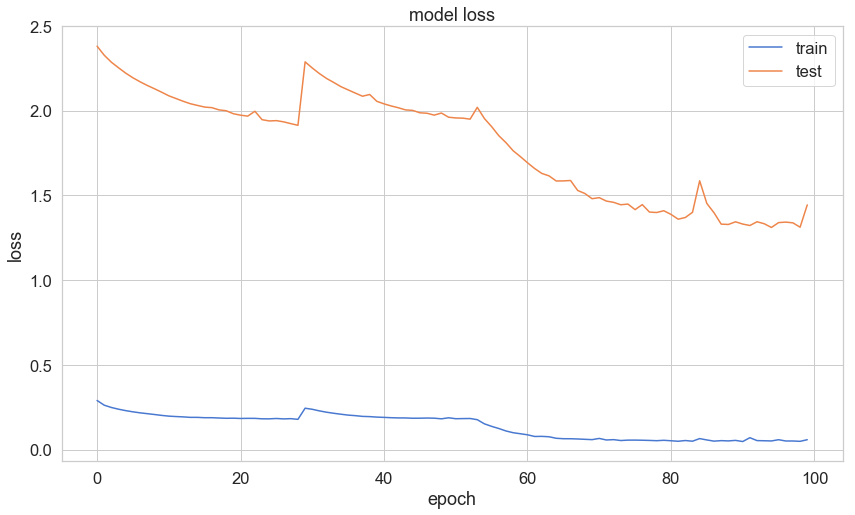

In [68]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [69]:
predictions = autoencoder.predict(X_test_enc)

In [70]:
mse = np.mean(np.power(X_test_enc - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

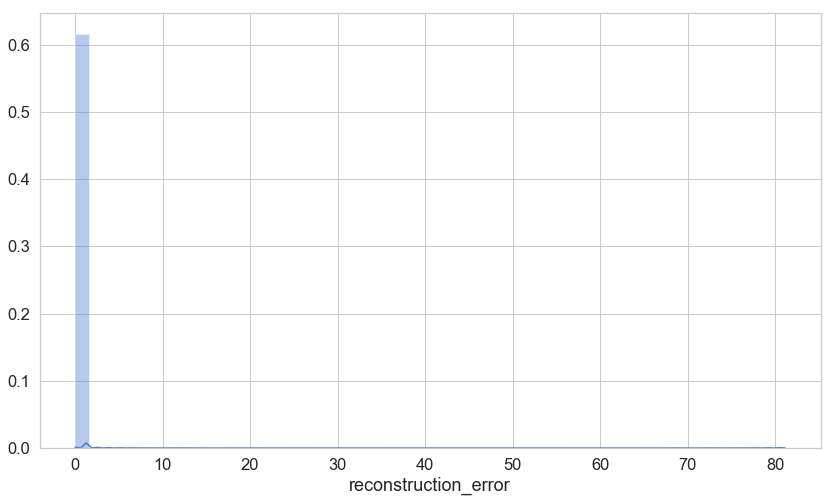

In [88]:
sns.distplot((error_df['reconstruction_error'][error_df['true_class']== 0]))

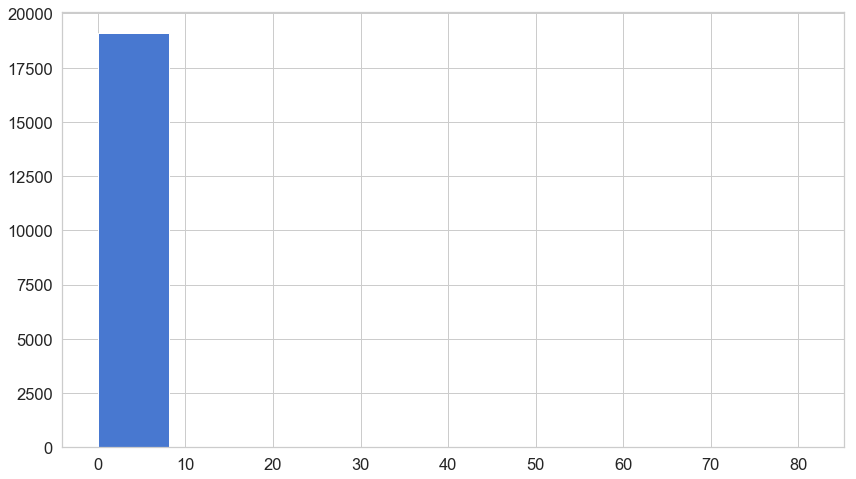

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

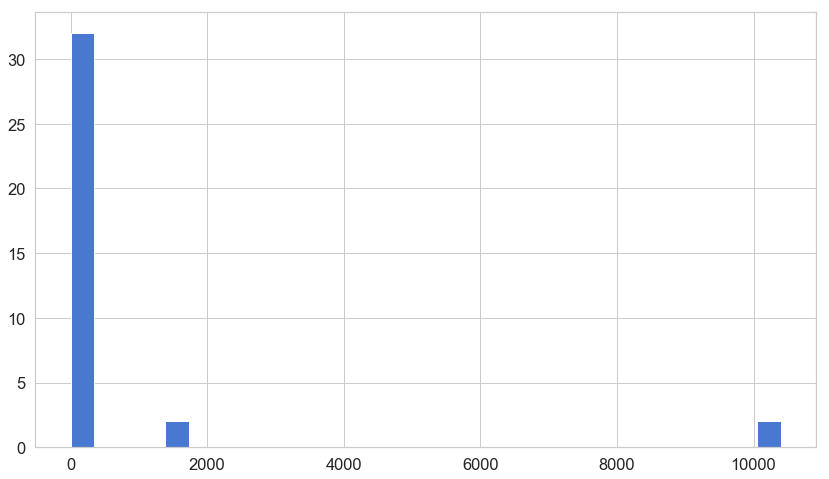

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=30)

In [45]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

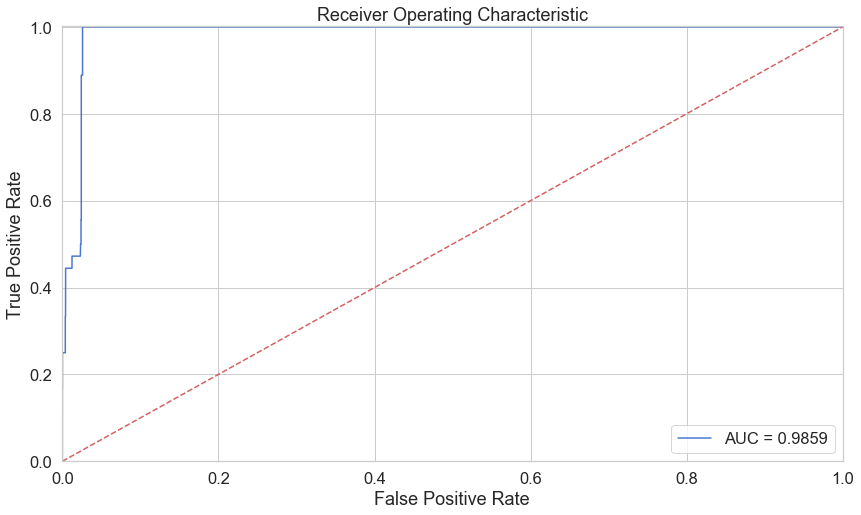

In [89]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [98]:
error_df[error_df['true_class']==1].describe()

,reconstruction_error,true_class
count,36.000000,36.0
mean,675.470147,1.0
std,2418.809155,0.0
min,0.179032,1.0
25%,0.258016,1.0
50%,0.339517,1.0
75%,1.168299,1.0
max,10398.482335,1.0


In [100]:
error_df[error_df['true_class']==0].describe()

,reconstruction_error,true_class
count,19097.000000,19097.0
mean,0.039433,0.0
std,0.601613,0.0
min,0.000101,0.0
25%,0.018259,0.0
50%,0.020882,0.0
75%,0.022401,0.0
max,81.135597,0.0


In [110]:
error_df.iloc[1000]

reconstruction_error    0.017941
true_class              0.000000
Name: 20225, dtype: float64

In [165]:
error_df.loc[error_df.reconstruction_error <= 4, 'Predicted'] = 0
error_df.loc[error_df.reconstruction_error > , 'Predicted'] = 1

In [166]:
f1_score(error_df.true_class,error_df.Predicted)

0.27272727272727276

In [158]:
(error_df.true_class==error_df.Predicted).mean()

0.9946166309517588

In [172]:
from sklearn.cluster import KMeans

In [174]:
km=KMeans(n_clusters=2,random_state=2)

In [176]:
km.fit(X_train_enc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

In [180]:
f1_score(y_test,km.predict(X_test_enc))

0.4482758620689656

In [182]:
(y_test==km.predict(X_test_enc)).mean()

0.9983274969947211

In [3]:
data=train.append(test)

In [4]:
grouped=data.groupby('AccountId')

In [5]:
profile=pd.DataFrame()
for name,group in grouped:
    print(name)
    group.set_index('TransactionStartTime',inplace=True)
    group['TransactionStartTime']=group.index
    group['TimeBetweenTransaction']=(group['TransactionStartTime'].diff()).fillna(0)
    group['TimeBetweenTransaction']=(group['TimeBetweenTransaction']/np.timedelta64(1, 's'))
    group['AmountBetweenTransaction']=(group['Amount'].diff()).fillna(0)
    group.loc[(group.TimeBetweenTransaction/3600 >= 1) | (group.TimeBetweenTransaction/3600 == 0), 
              'PreviousTransactionBetweenHour'] = 0
    group.fillna(1,inplace=True)
    group['NumberOfTransactionWithinHour']=group.groupby((group['PreviousTransactionBetweenHour']!=group['PreviousTransactionBetweenHour'].shift()).cumsum())['PreviousTransactionBetweenHour'].cumsum()
    group['AveAmtWithinPeriod']=group.groupby((group['PreviousTransactionBetweenHour']==group['PreviousTransactionBetweenHour'].shift()).cumsum())['Amount'].cumsum()/(group['NumberOfTransactionWithinHour'] + 1)
    if profile.shape[0]==0:
        profile=group
    else:
        profile=profile.append(group)
    #display(group.T)
    #break
    #display(profile.sort_values(by='AccountId'))

AccountId_1
AccountId_10
AccountId_100
AccountId_1000
AccountId_1001
AccountId_1002
AccountId_1003
AccountId_1004
AccountId_1005
AccountId_1006
AccountId_1007
AccountId_1008
AccountId_1009
AccountId_101
AccountId_1010
AccountId_1011
AccountId_1012
AccountId_1013
AccountId_1014
AccountId_1015
AccountId_1016
AccountId_1017
AccountId_1018
AccountId_1019
AccountId_102
AccountId_1020
AccountId_1021
AccountId_1022
AccountId_1023
AccountId_1024
AccountId_1025
AccountId_1026
AccountId_1027
AccountId_1028
AccountId_1029
AccountId_103
AccountId_1030
AccountId_1031
AccountId_1032
AccountId_1033
AccountId_1034
AccountId_1035
AccountId_1036
AccountId_1037
AccountId_1038
AccountId_1039
AccountId_104
AccountId_1040
AccountId_1041
AccountId_1042
AccountId_1043
AccountId_1044
AccountId_1045
AccountId_1046
AccountId_1047
AccountId_1048
AccountId_1049
AccountId_105
AccountId_1050
AccountId_1051
AccountId_1052
AccountId_1053
AccountId_1054
AccountId_1055
AccountId_1056
AccountId_1057
AccountId_1058
Accoun

In [7]:
#profile.to_csv('Userprofiles.csv')

In [9]:
data.nunique()

AccountId                 4841
Amount                    2099
BatchId                 139493
ChannelId                    5
CountryCode                  1
CurrencyCode                 1
CustomerId                7479
FraudResult                  2
PricingStrategy              4
ProductCategory             10
ProductId                   27
ProviderId                   6
SubscriptionId            4836
TransactionId           140681
TransactionStartTime    138574
Value                     1880
dtype: int64

In [11]:
profile.nunique()

AccountId                           4841
Amount                              2099
BatchId                           139493
ChannelId                              5
CountryCode                            1
CurrencyCode                           1
CustomerId                          7479
FraudResult                            2
PricingStrategy                        4
ProductCategory                       10
ProductId                             27
ProviderId                             6
SubscriptionId                      4836
TransactionId                     140681
Value                               1880
TransactionStartTime              138574
TimeBetweenTransaction             38600
AmountBetweenTransaction            4647
PreviousTransactionBetweenHour         2
NumberOfTransactionWithinHour       2001
AveAmtWithinPeriod                 16152
dtype: int64

In [12]:
profile.corr()

,Amount,CountryCode,FraudResult,PricingStrategy,Value,TimeBetweenTransaction,AmountBetweenTransaction,PreviousTransactionBetweenHour,NumberOfTransactionWithinHour,AveAmtWithinPeriod
Amount,1.000000,NaN,0.030532,-0.062074,0.968012,0.011381,0.411132,-0.027929,-0.051288,0.770004
CountryCode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FraudResult,0.030532,NaN,1.000000,0.000752,0.041238,0.031535,0.014972,0.020154,-0.060610,0.021505
PricingStrategy,-0.062074,NaN,0.000752,1.000000,-0.014819,0.059986,-0.001336,-0.133040,0.164326,-0.042366
Value,0.968012,NaN,0.041238,-0.014819,1.000000,0.004562,0.400937,-0.010230,-0.009221,0.753344
TimeBetweenTransaction,0.011381,NaN,0.031535,0.059986,0.004562,1.000000,0.008852,-0.315188,-0.096367,0.019101
AmountBetweenTransaction,0.411132,NaN,0.014972,-0.001336,0.400937,0.008852,1.000000,-0.008609,0.000914,0.086607
PreviousTransactionBetweenHour,-0.027929,NaN,0.020154,-0.133040,-0.010230,-0.315188,-0.008609,1.000000,0.304743,-0.049784
NumberOfTransactionWithinHour,-0.051288,NaN,-0.060610,0.164326,-0.009221,-0.096367,0.000914,0.304743,1.000000,-0.029349
AveAmtWithinPeriod,0.770004,NaN,0.021505,-0.042366,0.753344,0.019101,0.086607,-0.049784,-0.029349,1.000000


In [17]:
cc_profile=profile[['TransactionId','TimeBetweenTransaction','AmountBetweenTransaction',
         'PreviousTransactionBetweenHour','NumberOfTransactionWithinHour','AveAmtWithinPeriod']]

In [19]:
data_cc=data.merge(cc_profile,on='TransactionId')

In [20]:
data_cc.to_csv('Customer Profile.csv')